<a href="https://colab.research.google.com/github/Nivedithabp/Radicalism_Verbalized_NLP/blob/main/Keyword_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install sumy rake-nltk scikit-learn wordcloud matplotlib spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
# Import necessary libraries
import spacy
from rake_nltk import Rake
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from google.colab import files
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [9]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

In [10]:
# Function to preprocess text
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return tokens

In [18]:
!pip install nltk sumy
import nltk
nltk.download('punkt')

nltk.download('stopwords') # Download stopwords resource

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

# Function for TextRank keyword extraction using sumy
def extract_keywords_textrank(text):
    # The line below was causing the error. NLTK resources needs to be downloaded.
    # Added code to download NLTK 'punkt' resource before using sumy's Tokenizer.

    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    keywords = summarizer(parser.document, 10)  # Extract 10 keywords
    return [str(kw) for kw in keywords]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:


# Function for RAKE keyword extraction
def extract_keywords_rake(text):
    rake = Rake()
    rake.extract_keywords_from_text(text)
    return rake.get_ranked_phrases()

# Function for TF-IDF keyword extraction
def extract_keywords_tfidf(corpus):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
    X = vectorizer.fit_transform(corpus)
    keywords = vectorizer.get_feature_names_out()
    return keywords

# Function for n-gram extraction
def extract_ngrams(text, n):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform([text])
    return vectorizer.get_feature_names_out()

In [12]:
# Function for keyword visualization
def visualize_keywords(keywords):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [13]:
# Asking the user to choose between entering text or uploading a file
option = input("Would you like to upload a text file or enter text manually? Type 'file' for file upload or 'text' for manual entry: ")

if option.lower() == 'text':
    # Manually entering text
    user_text = input("Please enter your sample text: ")

elif option.lower() == 'file':
    # Uploading a file
    uploaded = files.upload()

    # Assuming a single file is uploaded and it's a .txt file
    file_name = next(iter(uploaded))  # Get the first uploaded file's name
    with open(file_name, 'r') as file:
        user_text = file.read()

else:
    print("Invalid option. Please run the cell again and enter either 'file' or 'text'.")



Would you like to upload a text file or enter text manually? Type 'file' for file upload or 'text' for manual entry: text
Please enter your sample text: Topic: "A World Without Borders: Why National Boundaries Should Be Abolished" Speech Outline: Introduction:  Briefly discuss the historical context of national borders. Introduce the radical idea: A future where nations as we know them cease to exist, and borders are abolished. Problem Statement:  Explain how borders create division, inequality, and conflict. Talk about how national boundaries hinder human potential, free movement, and global cooperation. Arguments:  Moral Argument: All humans are equal, and the concept of borders perpetuates discrimination based on geography. Economic Argument: Abolishing borders would allow for free movement of labor, maximizing economic potential across the globe. Humanitarian Argument: Refugee crises, wars, and the plight of asylum seekers are a direct result of rigid borders. A world without borde


Your input text is:

Topic: "A World Without Borders: Why National Boundaries Should Be Abolished" Speech Outline: Introduction:  Briefly discuss the historical context of national borders. Introduce the radical idea: A future where nations as we know them cease to exist, and borders are abolished. Problem Statement:  Explain how borders create division, inequality, and conflict. Talk about how national boundaries hinder human potential, free movement, and global cooperation. Arguments:  Moral Argument: All humans are equal, and the concept of borders perpetuates discrimination based on geography. Economic Argument: Abolishing borders would allow for free movement of labor, maximizing economic potential across the globe. Humanitarian Argument: Refugee crises, wars, and the plight of asylum seekers are a direct result of rigid borders. A world without borders would foster empathy and shared responsibility. Environmental Argument: Global cooperation is hindered by national interests. A 

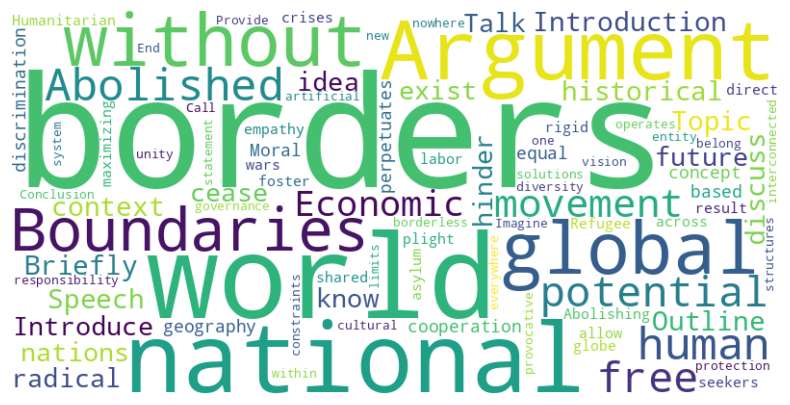

In [19]:
# Display the input text
print("\nYour input text is:\n")
print(user_text)

# Preprocess the text
processed_text = preprocess_text(user_text)
print("\nPreprocessed Text:", processed_text)

# Keyword extraction using various methods
# TextRank using sumy
keywords_textrank = extract_keywords_textrank(user_text)
print("\nTextRank Keywords:", keywords_textrank)

# RAKE
keywords_rake = extract_keywords_rake(user_text)
print("\nRAKE Keywords:", keywords_rake)

# TF-IDF (providing corpus as a list with one entry)
corpus = [user_text]
keywords_tfidf = extract_keywords_tfidf(corpus)
print("\nTF-IDF Keywords:", keywords_tfidf)

# n-grams (bigram example)
ngrams = extract_ngrams(user_text, 2)
print("\nBigrams:", ngrams)

# Visualization of keywords
visualize_keywords(keywords_textrank)